In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.rcParams['patch.edgecolor'] = 'black'

pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


# Data Exploration & Cleaning

## Integer Columns
The columns with only 2 unique values represent Booleans (0 or 1). In most cases, this boolean information is already on a household level.

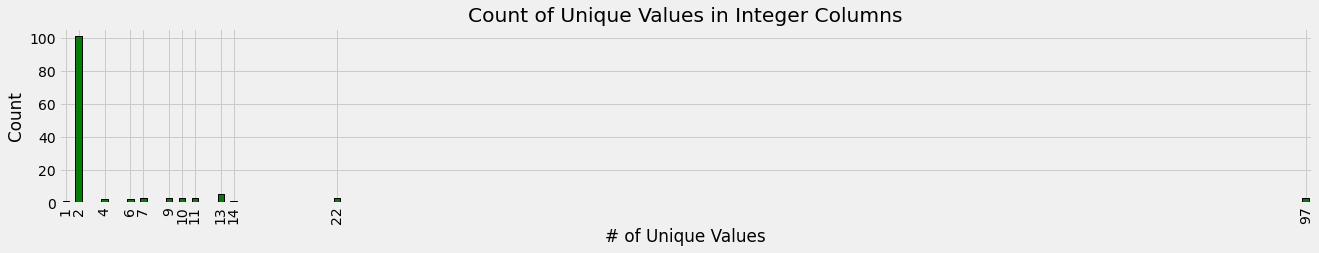

In [2]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'green', figsize = (20, 3),edgecolor = 'black', linewidth = 1);
plt.xlabel('# of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

## Float Columns

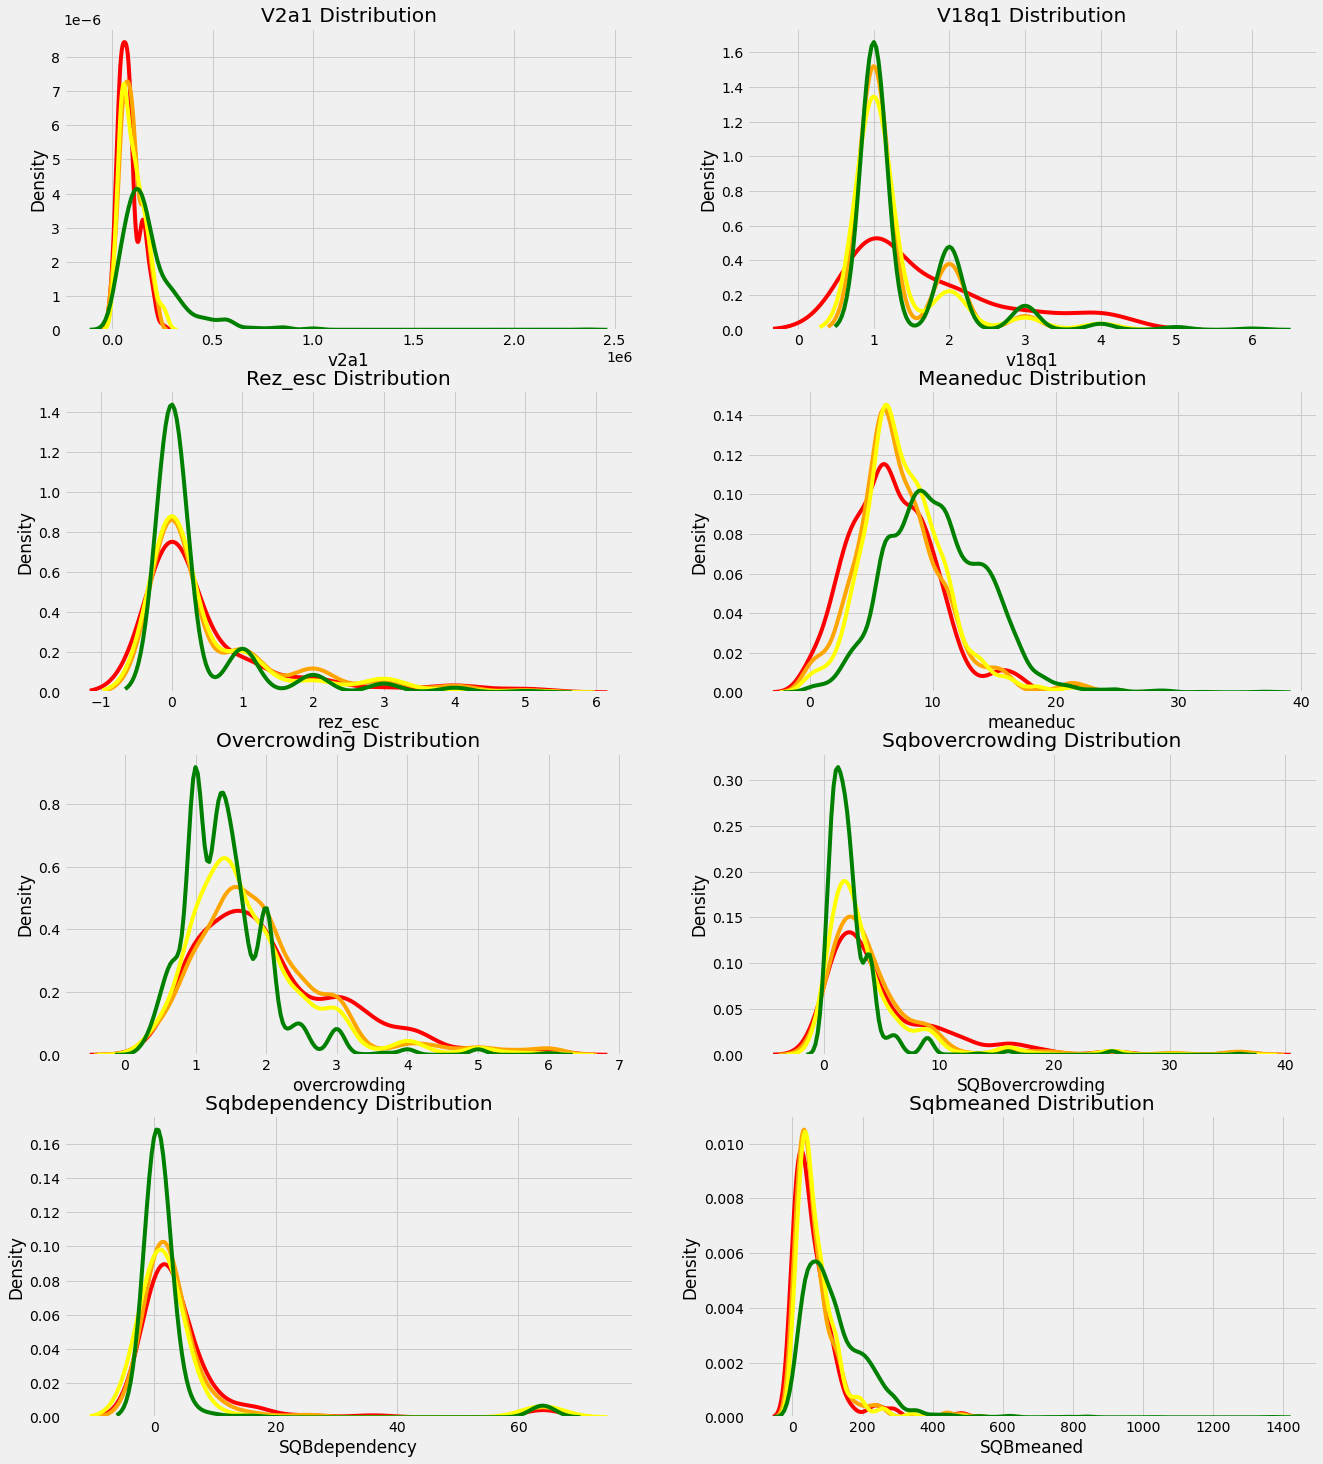

In [3]:
from collections import OrderedDict

plt.figure(figsize = (20, 10))

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'yellow', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

## Object Columns
The Id and idhogar object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning.

* dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0 

**For these three variables, "yes" = 1 and "no" = 0. We can correct the variables using a mapping and convert to floats.**

In [4]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [5]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


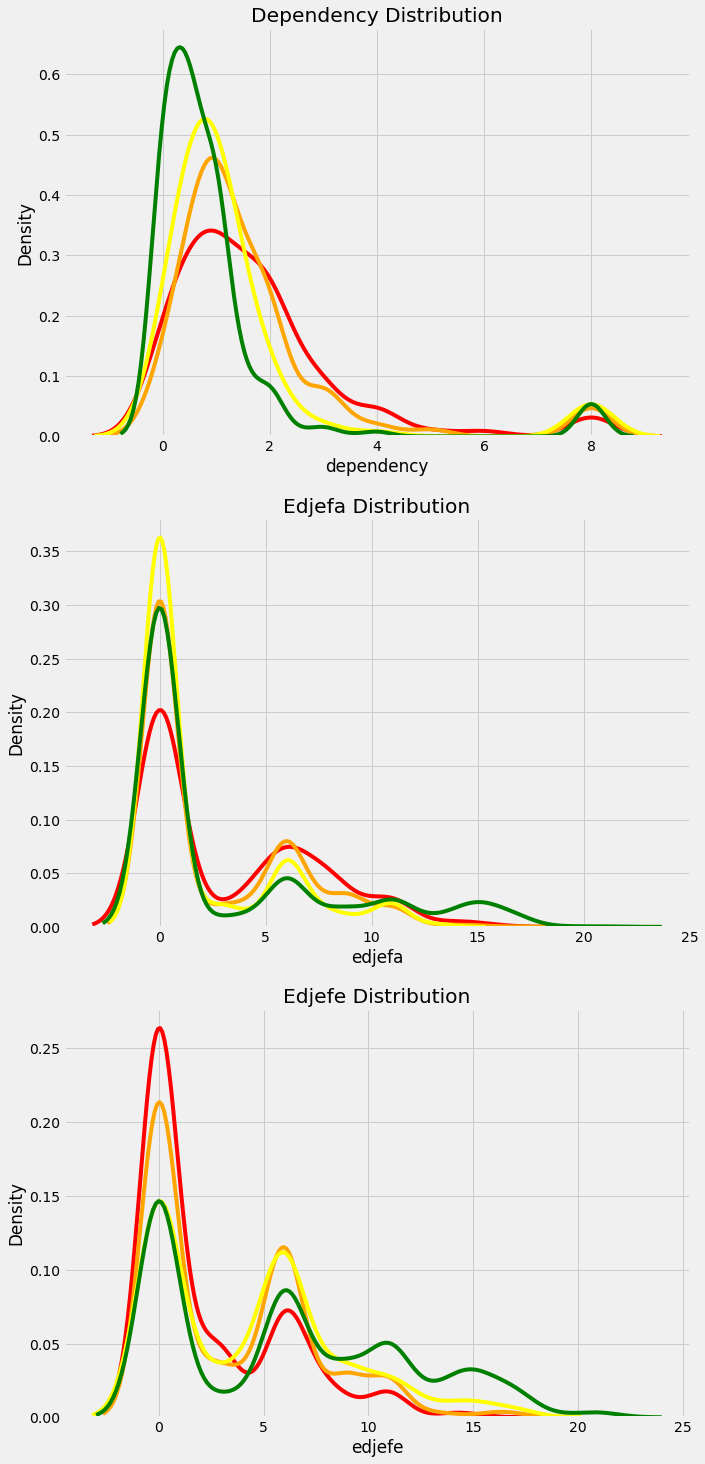

In [6]:
plt.figure(figsize = (10, 10))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the Target.

In [7]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution

Next, we look at how imbalanced the problem is. We look at only where parentesco1 == 1 because this is the head of household, the correct label for each household.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

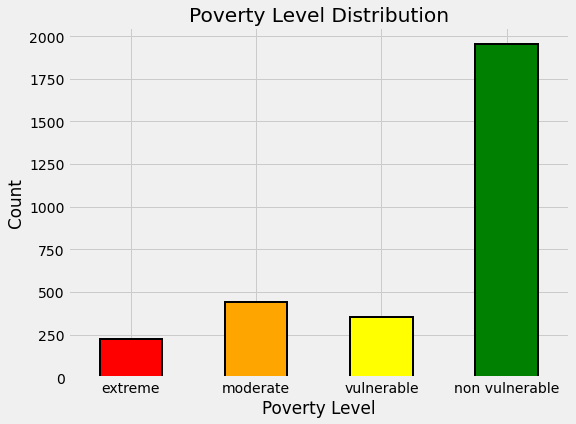

In [8]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([1,2,3,4], 
           list(poverty_mapping.values()), rotation = 0)
plt.title('Poverty Level Distribution');

label_counts

This shows that this is an imbalanced class problem. Thus, machine learning model can have a difficult time predicting the minority classes due to lesser examples.

One potential solution to imbalance class is oversampling.

## Addressing Wrong Labels

Some of the labels are not correct because individuals in the same household have a different poverty level. We will use the head of household as the true label.

**Identify Errors**

Firstly, lets check if there is only **one unique Target value** for each household.

The organizers tell us that the correct label is that for the head of household, where parentesco1 == 1

In [9]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('{} households where family members do not have the same target.'.format(len(not_equal)))

85 households where family members do not have the same target.


**Families without Heads of Household**

In [10]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('{} households without household head.'.format(households_no_head['idhogar'].nunique()))

# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households is without household head and have different labels.'.format(sum(households_no_head_equal == False)))

15 households without household head.
0 Households is without household head and have different labels.


**Correct Errors**

correct labels for the households that do have a head AND the members have different poverty levels.

In [11]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('{} households where the family members do not all have the same target.'.format(len(not_equal)))

0 households where the family members do not all have the same target.


## Missing Variables

In [12]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


**v18q1**: Number of tablets owned by a family

Lets look at the value counts of this variable. As it is a household variable, we'll only select the rows for the head of household.

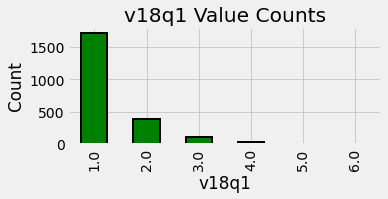

In [13]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (5, 2))
    df[col].value_counts().sort_index().plot.bar(color = 'green',
                                                 edgecolor = 'black',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); 
    plt.title(f'{col} Value Counts'); 
    plt.ylabel('Count')
    plt.show();
    
plot_value_counts(heads, 'v18q1')

Based on the present data, most hosuehold owned 1 tablet. However, we also need to think about the data that is missing. In this case, it could be that families with a nan in this category just do not own a tablet! If we look at the data definitions, we see that v18q indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [14]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

**Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.

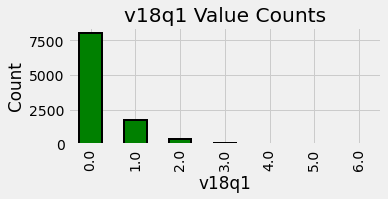

In [15]:
#Apply to main dataset
data['v18q1'] = data['v18q1'].fillna(0)
plot_value_counts(data,'v18q1', True)

**v2a1:** Monthly rent payment

We will also look at the distribution of tipovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

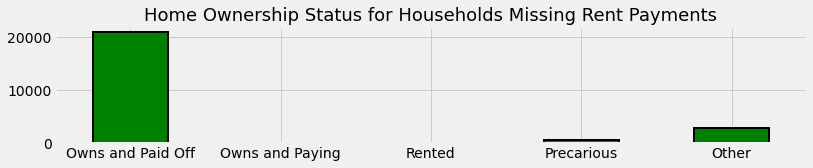

In [16]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (12, 2),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 0)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

The meaning of the home ownership variables is below:

* tipovivi1, =1 own and fully paid house
* tipovivi2, "=1 own,  paying in installments"
* tipovivi3, =1 rented
* tipovivi4, =1 precarious
* tipovivi5, "=1 other(assigned,  borrowed)"

Thus, we can see that the households that do not have monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [17]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

**rez_esc**: years behind in school

For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [18]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [19]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

After reading the discussions for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [20]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

## outlier

There is also one outlier in the rez_esc column. From the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

In [21]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables

In [22]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14,10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightblue',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightblue',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


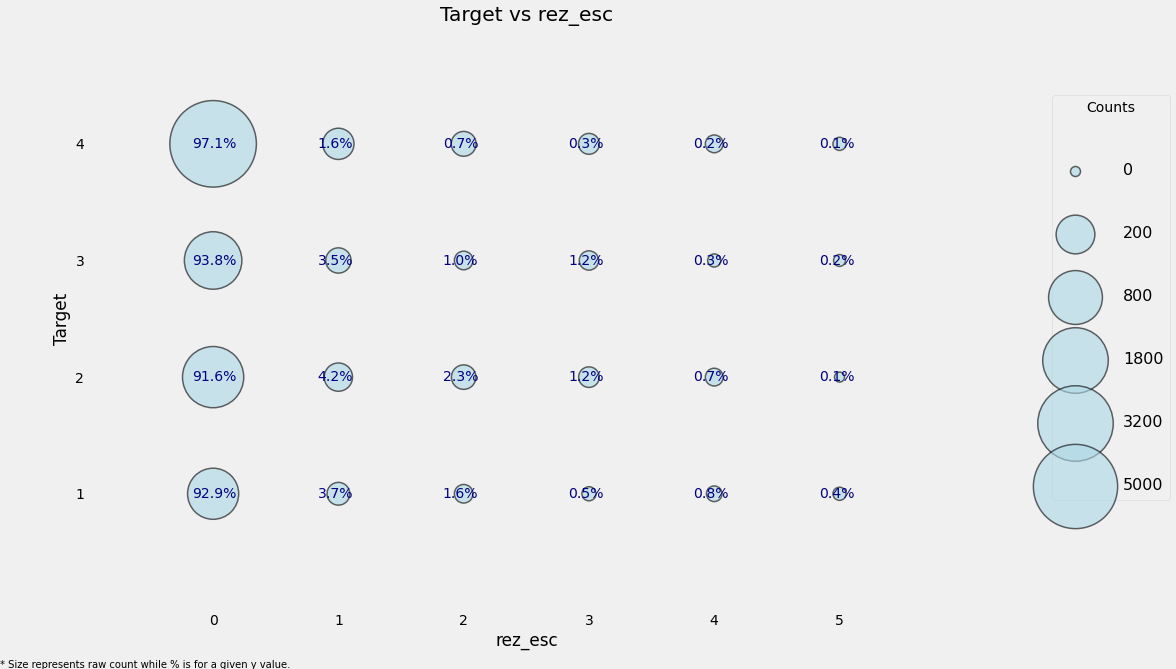

In [23]:
plot_categoricals('rez_esc', 'Target', data);

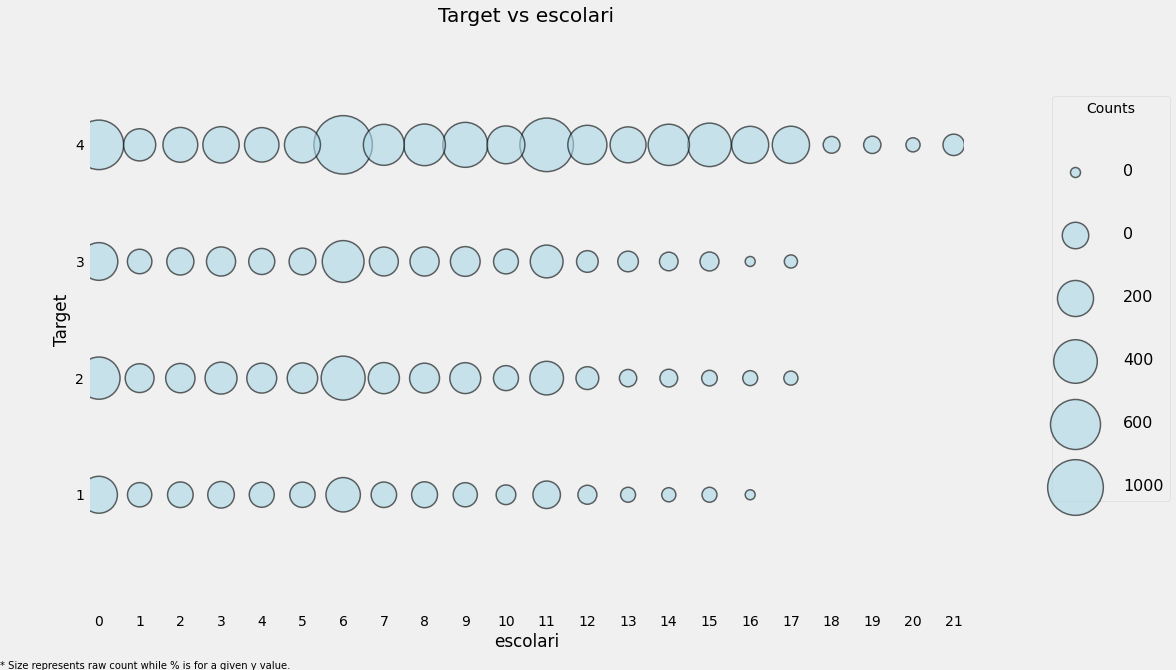

In [24]:
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as Imputation. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the median of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

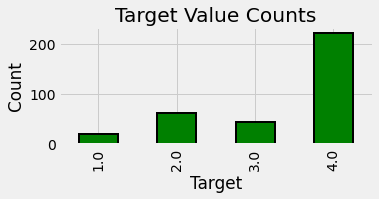

In [25]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

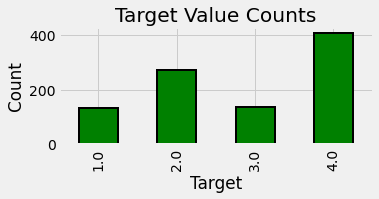

In [26]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

This represents an important point: sometimes the missing information is just as important as the information you are given.

In [27]:
data.head(10)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,v2a1-missing,rez_esc-missing
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4.0,False,False
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4.0,False,False
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4.0,False,False
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4.0,False,False
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4.0,False,False
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,121,1444,16,121,4,1.777778,1.0,121.0,1444,4.0,False,False
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,2,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,1,0,0,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,8,4,64,16,121,4,1.777778,1.0,121.0,64,4.0,Fa

# Feature Engineering
In this step, we will determine which column to be removed. There are too many useless features such as escolari squared, age squared, hogar_total squared etc..

We will remove them since all feature can be determined by the original features (unsquared). The Correlation of it proves:

In [28]:
df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)  
df_rem = df[['escolari','age','hogar_total','edjefe','hogar_nin','overcrowding','dependency','meaneduc','SQBescolari', 'SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency','SQBmeaned','agesq']]
df_rem.corr()

,escolari,age,hogar_total,edjefe,hogar_nin,overcrowding,dependency,meaneduc,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
escolari,1.000000,0.229498,-0.155071,0.276719,-0.270635,-0.255533,-0.163687,0.531671,0.943661,0.070639,-0.148555,0.332684,-0.221921,-0.180120,-0.078815,0.466749,0.070639
age,0.229498,1.000000,-0.332374,-0.022615,-0.481416,-0.320321,0.201321,-0.109337,0.173450,0.958142,-0.261336,-0.011809,-0.324266,-0.197389,0.303791,-0.077231,0.958142
hogar_total,-0.155071,-0.332374,1.000000,0.000063,0.749101,0.580533,-0.071063,-0.026296,-0.148912,-0.318815,0.952755,-0.025576,0.684126,0.418792,-0.204603,-0.055348,-0.318815
edjefe,0.276719,-0.022615,0.000063,1.000000,-0.049445,-0.072005,-0.123017,0.404089,0.311839,-0.043900,-0.031238,0.934219,-0.075136,-0.073746,-0.083730,0.351343,-0.043900
hogar_nin,-0.270635,-0.481416,0.749101,-0.049445,1.000000,0.615151,0.173317,0.004036,-0.248988,-0.440995,0.721217,-0.057041,0.885936,0.470832,-0.056186,0.012697,-0.440995
overcrowding,-0.255533,-0.320321,0.580533,-0.072005,0.615151,1.000000,0.029925,-0.181672,-0.239601,-0.296620,0.560283,-0.108250,0.593689,0.879101,-0.093700,-0.174856,-0.296620
dependency,-0.163687,0.201321,-0.071063,-0.123017,0.173317,0.029925,1.000000,-0.143515,-0.140314,0.313750,-0.010564,-0.094959,0.218472,0.073131,0.947312,-0.069745,0.313750
meaneduc,0.531671,-0.109337,-0.026296,0.404089,0.004036,-0.181672,-0.143515,1.000000,0.569720,-0.147221,-0.055162,0.496944,-0.046657,-0.145467,-0.140359,0.950371,-0.147221
SQBescolari,0.943661,0.173450,-0.148912,0.311839,-0.248988,-0.239601,-0.140314,0.569720,1.000000,0.052904,-0.140805,0.399042,-0.198131,-0.163278,-0.063329,0.523646,0.052904
SQBage,0.070639,0.958142,-0.318815,-0.043900,-0.440995,-0.296620,0.313750,-0.147221,0.052904,1.000000,-0.244086,-0.030039,-0.284503,-0.175584,0.396809,-0.106208,1.000000


agesq = SQBage -> duplicate row!

For easy view, we see it from a heatmap

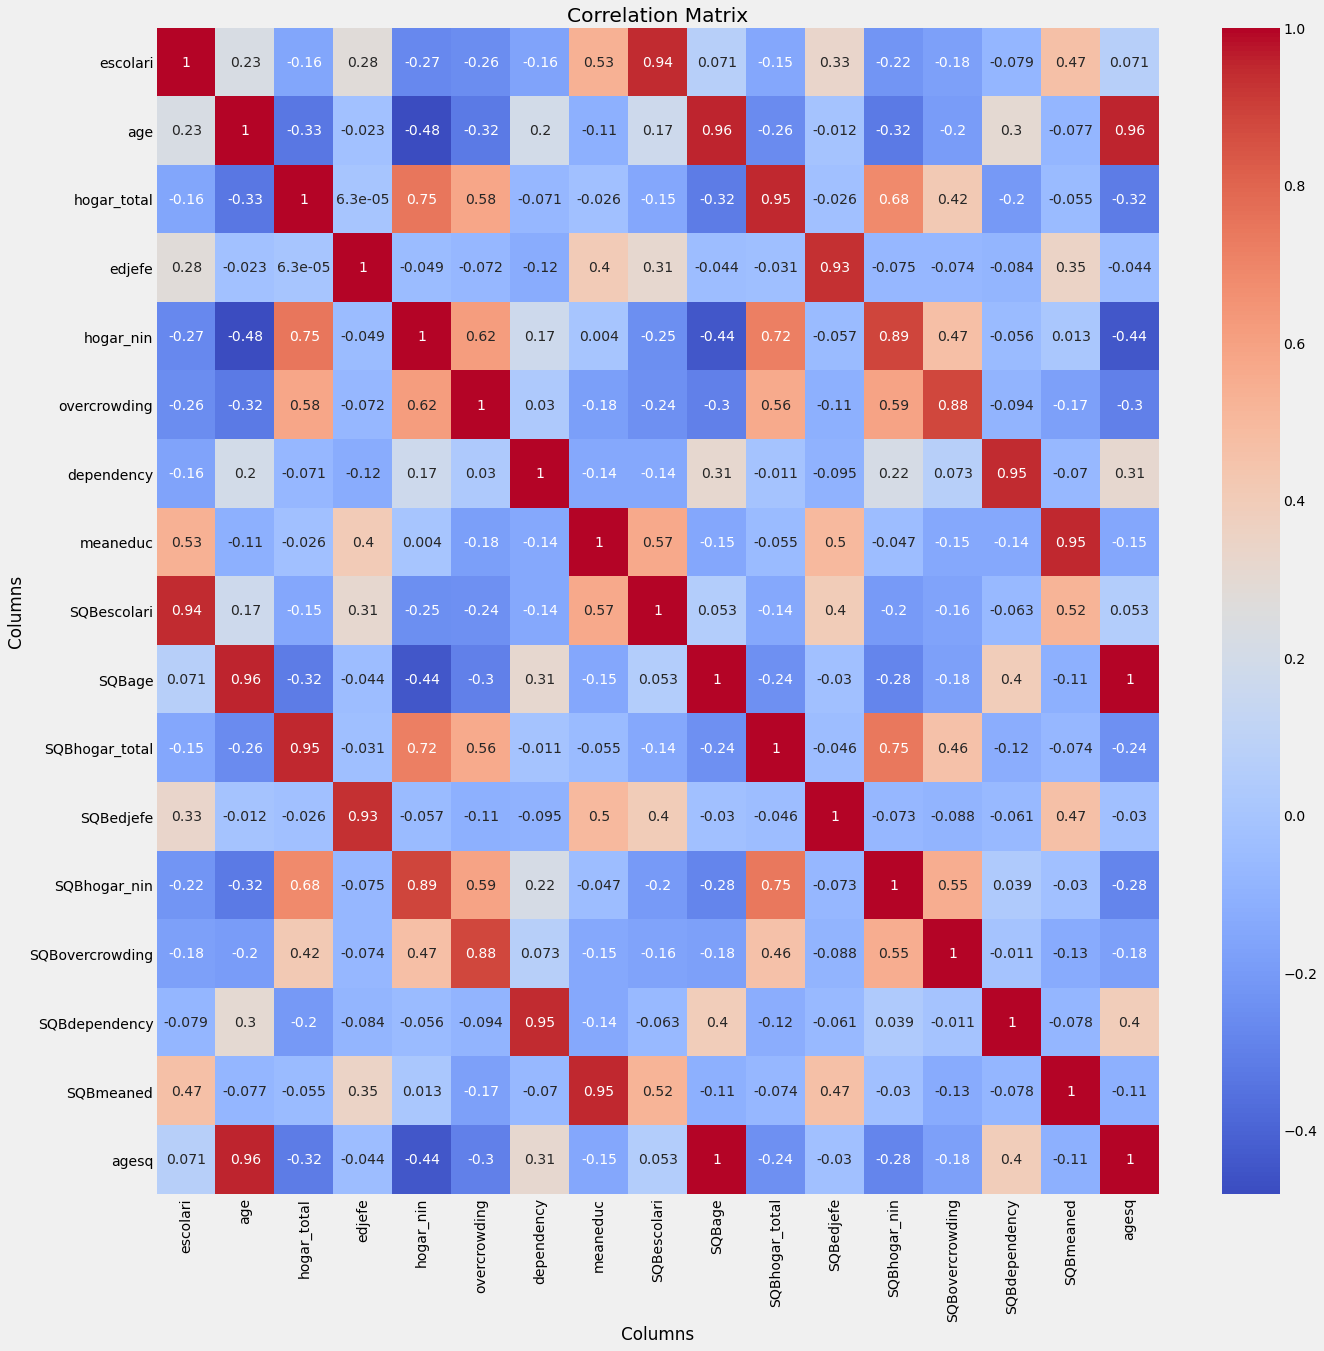

In [29]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_rem.corr(), ax=ax, cmap= 'coolwarm', annot=True).set(
    title = 'Correlation Matrix', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

Thus, we will remove all the column "squared" columns to reduce our dimension.

In [30]:
df = df.drop(['SQBescolari', 'SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency','SQBmeaned','agesq'], axis=1)
df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,v2a1-missing,rez_esc-missing
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4.0,False,False
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4.0,False,False
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4.0,False,False
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4.0,False,False
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4.0,False,False


Everything will be easier to determine and compare with percentage. Thus, we will add/drop columns that can be determine by percentage, as it can be unfair sometimes to compare the actual number

percentage of dependency based on number of people below 12 and above 65 / number of adults

In [31]:
df['num_adult'] = df['hogar_adul'] - df['hogar_mayor']
df['need_dependence'] = df['hogar_nin'] + df['hogar_mayor']
# for x in df['num_adult']:
#     if x == 0:
#         df['actual_dependency'] = -1
#     else:
#         df['actual_dependency'] = df['need_dependence'] / df['num_adult']
# df['actual_dependency'].replace({'inf': -1}).astype(float)
df['dependency_ratio'] = df['need_dependence'] / df['num_adult']
df.loc[df['num_adult'] == 0, "dependency_ratio"] = -1

number of total electronic products they have (computer, phone etc).

Although we cannot get exact number of electronic product they have, but at least we can get a rough estimates.

In [32]:
df['total_elec_prod'] = df['computer'] + df['television'] + df['qmobilephone'] + df['v18q1'] + df['refrig']

df.head(10)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,v2a1-missing,rez_esc-missing,num_adult,need_dependence,dependency_ratio,total_elec_prod
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4.0,False,False,1,0,0.0,2.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4.0,False,False,0,1,-1.0,3.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4.0,False,False,0,1,-1.0,1.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4.0,False,False,2,2,1.0,5.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4.0,False,False,2,2,1.0,5.0
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,4.0,False,False,2,2,1.0,5.0
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,2,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,1,0,0,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,8,4.0,False,False,2,2,1.0,5.0
7,ID_3e04e571e,130000.0,1,2,0,1,1,0,0.0,0,1,1,2,1,3,2,2,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,d6dae86b7,2,2,0,

monthly rental and education level

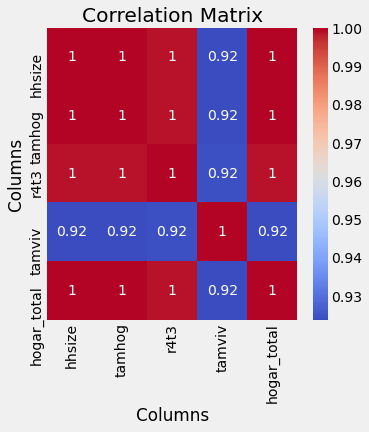

In [33]:
to_check = df[['hhsize','tamhog','r4t3','tamviv','hogar_total']]

fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(to_check.corr(), ax=ax, cmap= 'coolwarm', annot=True).set(
    title = 'Correlation Matrix', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

Seems like all these variable overlaps. All of the variable (except tamviv) determines the number of people in the household. The perfect correlation shows it. Thus, we will keep one of it only to reduce unnecessary dimension.

In [34]:
df = df.drop(['tamhog','r4t3','hogar_total'], axis=1)
df.head(10)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,v2a1-missing,rez_esc-missing,num_adult,need_dependence,dependency_ratio,total_elec_prod
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,10,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4.0,False,False,1,0,0.0,2.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,12,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4.0,False,False,0,1,-1.0,3.0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,11,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4.0,False,False,0,1,-1.0,1.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4.0,False,False,2,2,1.0,5.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4.0,False,False,2,2,1.0,5.0
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,11,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,4.0,False,False,2,2,1.0,5.0
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,2,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,1.0,11.0,0.0,11.0,0,1,0,0,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,8,4.0,False,False,2,2,1.0,5.0
7,ID_3e04e571e,130000.0,1,2,0,1,1,0,0.0,0,1,1,2,1,3,2,2,4,0,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,d6dae86b7,2,2,0,1.0,9.0,0.0,10.0,1,0,0,0,0,0,0,0,0,1,4.000000,0,0,1,0,0,0,0,1,1,1,0,0,

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


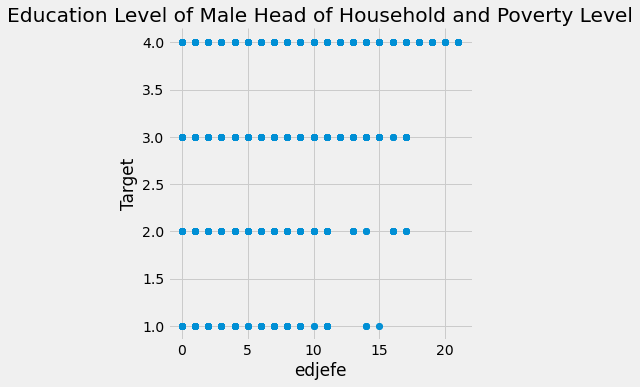

In [35]:
sns.lmplot('edjefe', 'Target', data = data, fit_reg=False);
plt.title('Education Level of Male Head of Household and Poverty Level');

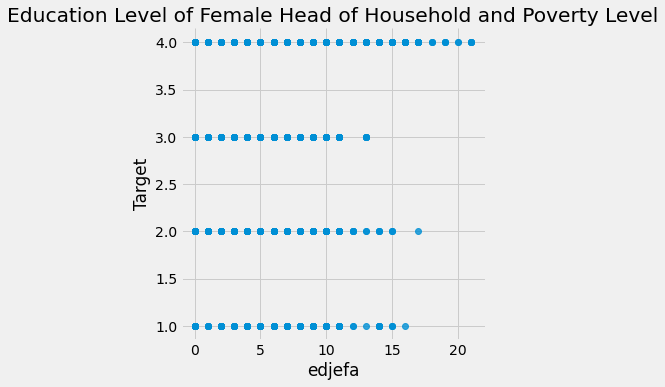

In [36]:
sns.lmplot('edjefa', 'Target', data = data, fit_reg=False);
plt.title('Education Level of Female Head of Household and Poverty Level');

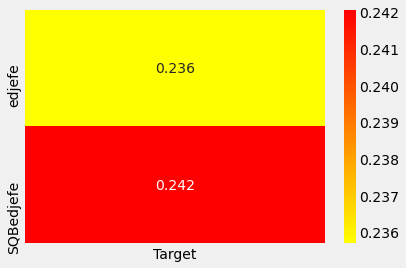

In [37]:
corr_matrix = heads.corr()

sns.heatmap(corr_matrix.loc[corr_matrix['edjefe'].abs() > 0.9, corr_matrix['Target'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

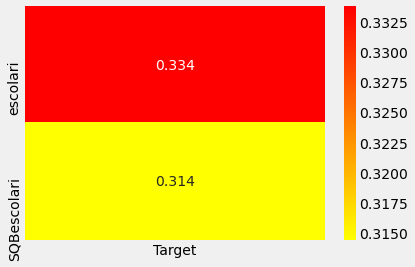

In [38]:
sns.heatmap(corr_matrix.loc[corr_matrix['escolari'].abs() > 0.9, corr_matrix['Target'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

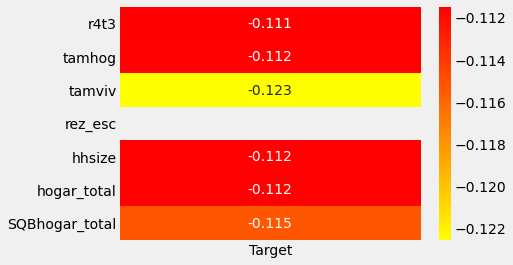

In [39]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['Target'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


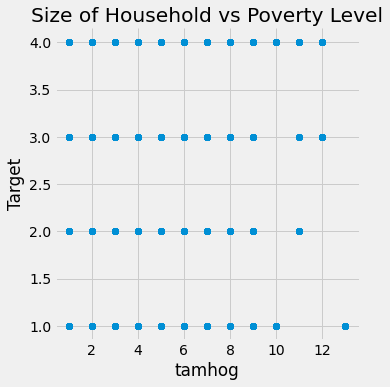

In [40]:
sns.lmplot('tamhog', 'Target', data = data, fit_reg=False);
plt.title('Size of Household vs Poverty Level');

In [41]:
from scipy.stats import spearmanr

In [42]:
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
           feature     pcorr
0        hogar_nin -0.266309
1             r4t1 -0.260917
2     SQBhogar_nin -0.256824
3     overcrowding -0.234954
4  SQBovercrowding -0.219318

Most positively correlated variables:
         feature     pcorr
121    cielorazo  0.295249
122  SQBescolari  0.314397
123     meaneduc  0.333652
124     escolari  0.333791
125       Target  1.000000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


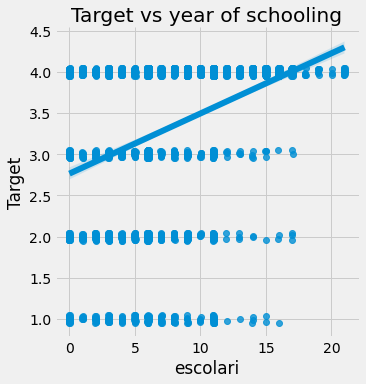

In [43]:
sns.lmplot('escolari', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs year of schooling');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


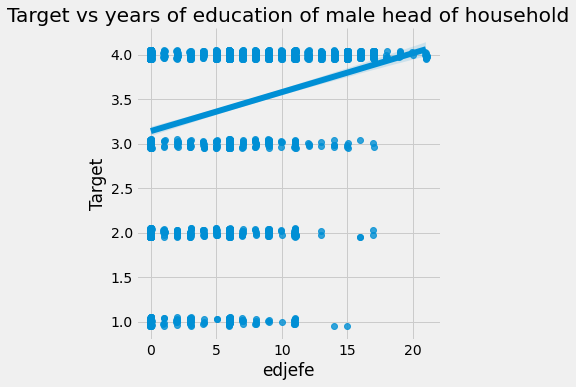

In [44]:
sns.lmplot('edjefe', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs years of education of male head of household');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


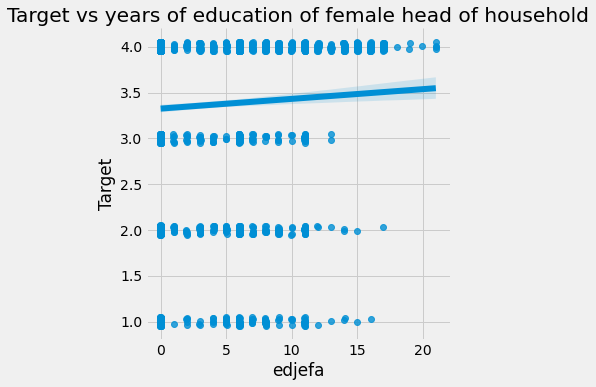

In [45]:
sns.lmplot('edjefa', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs years of education of female head of household');

In [46]:
id_ = ['Id', 'idhogar', 'Target']

ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

# Feature Engineering - Household Level

In [47]:
#subset to the heads of household and then to the household level variables.
hh = data.loc[data['parentesco1'] == 1, :]
hh = hh[id_ + hh_bool + hh_cont + hh_ordered]
hh.shape
hh.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,v18q1,tamhog,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,190000.0,0.0,10.0,0.0,10.0,1.000000,3,0,1,1,0,0,0,0,1,1,0.0,1,1,1,0,1,0,1,1,1
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,135000.0,8.0,12.0,0.0,12.0,1.000000,4,0,1,1,0,0,0,0,1,1,1.0,1,1,1,0,1,1,1,1,1
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,False,0.0,8.0,0.0,11.0,11.0,0.500000,8,0,0,0,0,1,1,0,1,1,0.0,1,1,1,0,1,1,1,2,0
5,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,180000.0,1.0,11.0,0.0,11.0,1.333333,5,0,2,2,1,1,2,1,3,4,1.0,4,4,4,2,2,0,4,3,3
8,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,130000.0,1.0,9.0,0.0,10.0,4.000000,2,0,1,1,2,1,3,2,2,4,0.0,4,4,4,2,2,0,4,1,1


### Remove Redundant Household Variables
identify any variables with a greater than 0.95 absolute magnitude correlation.

In [48]:
# Create correlation matrix
corr_matrix = hh.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [49]:
#These show one out of each pair of correlated variables. To find the other pair, we can subset the corr_matrix.
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


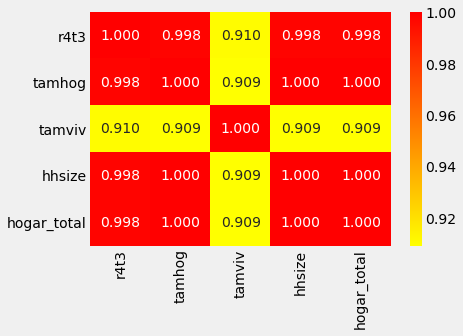

In [50]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

In [51]:
#drop columns tamhog, hogar_total, r4t3
hhold = hh.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

Since tamhog and hogar_total has perfect correlation with hhsize, we can identify them as redundant variables and remove them. tamviv is not the same as tamviv as there might be family members that are not living in the household.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


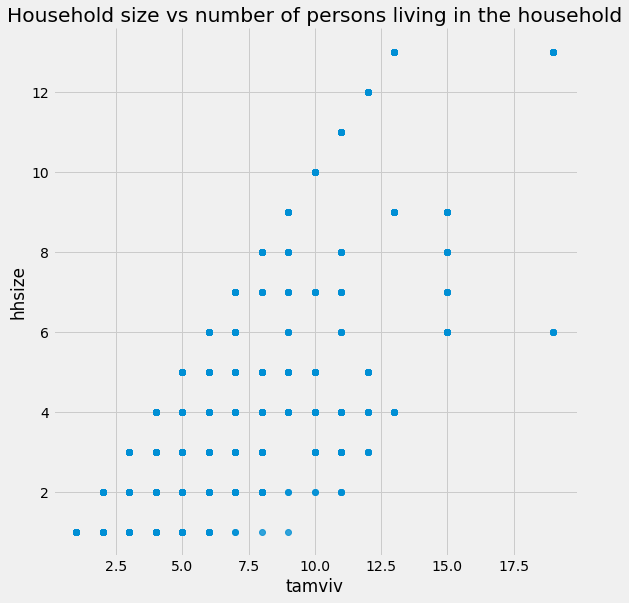

In [52]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

### Extract categorical features

In [53]:
binary_cat_features = [col for col in hhold.columns if hhold[col].value_counts().shape[0] == 2]

In [54]:
# adult = Number of adults in household - # of individuals 65+ in the household
hhold['adult'] = hhold['hogar_adul'] - hhold['hogar_mayor']
#dependency_count = Number of children 0 to 19 in household + # of individuals 65+ in the household
hhold['dependency_count'] = hhold['hogar_nin'] + hhold['hogar_mayor']
#denpendecy = dependency count / adult <65 years old
hhold['dependency'] = hhold['dependency_count'] / hhold['adult']

hhold['dependency'] = hhold['dependency'].replace({np.inf: 0})

#child_percent = Number of children 0 to 19 in household / household size
hhold['child_percent'] = hhold['hogar_nin'] / hhold['hhsize']
#elder_percent = # of individuals 65+ in the household / household size
hhold['elder_percent'] = hhold['hogar_mayor'] / hhold['hhsize']
#adult_percent = Number of adults in household /household size
hhold['adult_percent'] = hhold['hogar_adul'] / hhold['hhsize']
#male<12years by household size = Males younger than 12 years of age/household size
hhold['males_younger_12_years_in_household_size'] =hhold['r4h1'] / hhold['hhsize']
#male>12years by household size = Males 12 years of age and older/household size
hhold['males_older_12_years_in_household_size'] = hhold['r4h2'] /hhold['hhsize']
#male by household = Total males in the household/household size
hhold['males_in_household_size'] = hhold['r4h3'] / hhold['hhsize']
#female<12years by household size = Females younger than 12 years of age/household size
hhold['females_younger_12_years_in_household_size'] = hhold['r4m1'] / hhold['hhsize']
#female>12years by household size = Females 12 years of age and older/household size
hhold['females_older_12_years_in_household_size'] = hhold['r4m2'] /hhold['hhsize']
#Total females in the household = Total females in the household/household size
hhold['females_in_household_size'] =hhold['r4m3'] /hhold['hhsize']
#person<12years in household = persons younger than 12 years of age/household size
hhold['persons_younger_12_years_in_household_size'] = hhold['r4t1'] / hhold['hhsize']
#person>12years in household = persons 12 years of age and older/household size
hhold['persons_older_12_years_in_household_size'] = hhold['r4t2'] / hhold['hhsize']

In [55]:
#overcrowding room and bedroom =  Overcrowding by bedrooms =1 + Overcrowding by rooms =1 
hhold['overcrowding_room_and_bedroom'] = (hhold['hacdor'] + hhold['hacapo'])/2
#child between 12-19 = Number of children 0 to 19 in household - persons younger than 12 years of age
hhold['age_12_19'] = hhold['hogar_nin'] -hhold['r4t1']

### Feature Per Capita

In [56]:
#phone per capita = # of mobile phones/# of person living in the household
hhold['phones-per-capita'] =hhold['qmobilephone'] / hhold['tamviv']
#tablet per capita = number of tablets household owns/# of person living in the household
hhold['tablets-per-capita'] = hhold['v18q1'] / hhold['tamviv']
#rooms per capita = number of all rooms in the house/# of person living in the household
hhold['rooms-per-capita'] = hhold['rooms'] / hhold['tamviv']
#rent per capita = Monthly rent payment/# of person living in the household
hhold['rent-per-capita'] = hhold['v2a1'] / hhold['tamviv']

### Rent Per Family

In [57]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'hhsize']
new_feats = []
for col in family_size_features:
    #v2a1: Monthly rent payment
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    hhold[new_col_name] = hhold['v2a1'] / hhold[col]
    
# filled column that has infinite values with 0
for col in new_feats:
    hhold[col].replace([np.inf], np.nan, inplace=True)
    hhold[col].fillna(0, inplace=True)

### Room Per Family

In [58]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    hhold[new_col_name] = hhold['rooms'] / hhold[col]
for col in new_feats:
    hhold[col].replace([np.inf], np.nan, inplace=True)
    hhold[col].fillna(0, inplace=True)

### BedRoom Per Family

In [59]:
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    hhold[new_col_name] = hhold['bedrooms'] / hhold[col]

for col in new_feats:
    hhold[col].replace([np.inf], np.nan, inplace=True)
    hhold[col].fillna(0, inplace=True)

### Tablet Per Family

In [60]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    hhold[new_col_name] = hhold['v18q1'] / hhold[col]

for col in new_feats:
    hhold[col].replace([np.inf], np.nan, inplace=True)
    hhold[col].fillna(0, inplace=True)

### Phone Per Family

In [61]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    hhold[new_col_name] = hhold['qmobilephone'] / hhold[col]
    
for col in new_feats:
    hhold[col].replace([np.inf], np.nan, inplace=True)
    hhold[col].fillna(0, inplace=True)

### Combination of features
mulitification of each features generates new categorical features

### Electronic Feature

In [62]:
#combination of electrical devices including Computer, mobilephone, television, refriger and tablet
hhold['electronics'] = hhold['computer'] * hhold['qmobilephone'] * hhold['television'] *hhold['v18q1'] * hhold['refrig']
hhold['no_appliances'] = hhold['refrig'] + hhold['computer'] + hhold['television'] + hhold['qmobilephone']

In [63]:
#total number of phone and tablet
hhold['tabulet_x_qmobilephone'] = hhold['v18q1'] * hhold['qmobilephone']

### Living Environment Feature

In [64]:
# condition of wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]
        
# condition of wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]
        
#condition of roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]
        
#Condition of the three features, wall, floor and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            hhold[new_col_name] = hhold[col1] * hhold[col2]* hhold[col3]

In [65]:
#material of wall+ floor
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]
        
#material of floor + Roof
for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]
        
#material of wall + Roof
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2] 
        
#combination of materials used in wall, roof and floor     
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            hhold[new_col_name] = hhold[col1] * hhold[col2]*hhold[col3]

### Water Feature

In [66]:
# water provision and toilet
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]

### Hygiene Feature

In [67]:
#toilet and rubbish
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]

### Education Feature

In [68]:
#Education based on region 
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['meaneduc']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        hhold[new_col_name] = hhold[col1] * hhold[col2]

### Drop Feature with One value

In [69]:
#number of features
print(hhold.shape)

(10307, 564)


In [70]:
#drop columns with only one value
cols_with_only_one_value = []
for col in hhold.columns:
    if col == 'Target':
        continue
    if hhold[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredother_x_pisoother
new_paredother_x_pisonatur
new_paredother_x_pisonotiene
new_paredzocalo_x_techocane
new_paredzocalo_x_techootro
new_pareddes_x_techoentrepiso
new_pareddes_x_techocane
new_pareddes_x_techootro
new_paredzinc_x_techoentrepiso
new_paredzinc_x_techocane
new_paredzinc_x_techootro
new_paredfibras_x_techoentrepiso
new_paredfibras_x_techootro
new_paredother_x_techoentrepiso
new_paredother_x_techocane
new_paredblolad_x_pisocemento_x_techocane
new_paredblolad_x_pisoother_x_techoentrepiso
new_paredblolad_x_pisoother_x_techocane
new_paredblolad_x_pisonatur_x_techozinc
new_paredblolad_x_pisonatur_x_techoentrepiso
new_paredblolad_x_pisonatur_x_techocane
new_paredblolad_x_pisonotiene_x_techoentrepiso
new_paredblolad_x_pisonotiene_x_techocane
new_paredblolad_x_pisonotiene_x_techootro
new_pared

In [71]:
hhold.drop(cols_with_only_one_value, axis=1, inplace=True)

In [72]:
#number of features after drop 
print(hhold.shape)
hhold.columns

(10307, 396)


Index(['Id', 'idhogar', 'Target', 'hacdor', 'hacapo', 'v14a', 'refrig',
       'paredblolad', 'paredzocalo', 'paredpreb',
       ...
       'new_sanitario5_x_elimbasu3', 'new_sanitario5_x_elimbasu4',
       'new_sanitario6_x_elimbasu1', 'new_sanitario6_x_elimbasu3',
       'new_lugar1_x_meaneduc', 'new_lugar2_x_meaneduc',
       'new_lugar3_x_meaneduc', 'new_lugar4_x_meaneduc',
       'new_lugar5_x_meaneduc', 'new_lugar6_x_meaneduc'],
      dtype='object', length=396)

In [73]:
#find out the top 20 positive/negative feature that has high/low correlation in determing the poverty.
correlation = hhold.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 positive feature: 
Target                                      1.000000
meaneduc                                    0.333652
phones-per-capita                           0.299026
new_epared3_x_eviv3                         0.298196
cielorazo                                   0.295249
eviv3                                       0.293540
new_etecho3_x_eviv3                         0.290338
new_epared3_x_etecho3_x_eviv3               0.288869
new_paredblolad_x_pisomoscer                0.281393
epared3                                     0.280947
new_epared3_x_etecho3                       0.276940
pisomoscer                                  0.275452
new_paredblolad_x_pisomoscer_x_techozinc    0.270626
new_lugar1_x_meaneduc                       0.266934
adult_percent                               0.263882
etecho3                                     0.261142
paredblolad                                 0.254469
new_paredblolad_x_techozinc                 0.242040
edjefe         

# Feature Engineering - Individual Level

Lets first look at individual variables that are highly correlated and drop it.

In [74]:
ind = data[id_ + ind_bool + ind_ordered]
print(ind.shape)

# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print('redundent individual variable: ',to_drop)
ind = ind.drop(columns = 'male')

(33413, 40)
redundent individual variable:  ['female']


Change the 9 instlevel (one hot encoded) into an ordinal column.

In [75]:
print(ind[[c for c in ind if c.startswith('instlevel')]].head())
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instlevel')]]), axis = 1)

#Drop instlevel cols
ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])

print(ind.shape)

   instlevel1  instlevel2  instlevel3  instlevel4  instlevel5  instlevel6  \
0           0           0           0           1           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           1           0   
3           0           0           0           1           0           0   
4           0           0           0           0           1           0   

   instlevel7  instlevel8  instlevel9  
0           0           0           0  
1           0           1           0  
2           0           0           0  
3           0           0           0  
4           0           0           0  
(33413, 31)


Construct feature based on individual variables

In [76]:
# divide the years of schooling by the age.
ind['escolari/age'] = ind['escolari'] / ind['age']
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
print(ind.columns)
ind.head()

Index(['Id', 'idhogar', 'Target', 'v18q', 'dis', 'female', 'estadocivil1',
       'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',
       'estadocivil6', 'estadocivil7', 'parentesco1', 'parentesco2',
       'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6',
       'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10',
       'parentesco11', 'parentesco12', 'mobilephone', 'rez_esc-missing',
       'rez_esc', 'escolari', 'age', 'inst', 'escolari/age', 'inst/age',
       'tech'],
      dtype='object')


,Id,idhogar,Target,v18q,dis,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,mobilephone,rez_esc-missing,rez_esc,escolari,age,inst,escolari/age,inst/age,tech
0,ID_279628684,21eb7fcc1,4.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,False,0.0,10,43,3,0.232558,0.069767,1
1,ID_f29eb3ddd,0e5d7a658,4.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,False,0.0,12,67,7,0.179104,0.104478,2
2,ID_68de51c94,2c7317ea8,4.0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,11,92,4,0.119565,0.043478,0
3,ID_d671db89c,2b58d945f,4.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,False,1.0,9,17,3,0.529412,0.176471,2
4,ID_d56d6f5f5,2b58d945f,4.0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,False,0.0,11,37,4,0.297297,0.108108,2


Aggregate individual variables to household level

In [77]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range'

def aggregator(df, groupby_col, agg_m):
    agg_df = df.groupby(groupby_col).agg(agg_m)
    
    # Rename columns
    new_col = []
    for col in agg_df.columns.levels[0]:
        for stat in agg_df.columns.levels[1]:
            new_col.append(f'{col}_{stat}')
    agg_df.columns = new_col
    return agg_df

ind_agg = aggregator(ind.drop(columns='Target'), 'idhogar', ['min', 'max', 'sum', 'count', 'std', range_])

In [78]:
#ind_agg.columns.tolist()
ind_agg.head()

,v18q_min,v18q_max,v18q_sum,v18q_count,v18q_std,v18q_range,dis_min,dis_max,dis_sum,dis_count,dis_std,dis_range,female_min,female_max,female_sum,female_count,female_std,female_range,estadocivil1_min,estadocivil1_max,estadocivil1_sum,estadocivil1_count,estadocivil1_std,estadocivil1_range,estadocivil2_min,estadocivil2_max,estadocivil2_sum,estadocivil2_count,estadocivil2_std,estadocivil2_range,estadocivil3_min,estadocivil3_max,estadocivil3_sum,estadocivil3_count,estadocivil3_std,estadocivil3_range,estadocivil4_min,estadocivil4_max,estadocivil4_sum,estadocivil4_count,estadocivil4_std,estadocivil4_range,estadocivil5_min,estadocivil5_max,estadocivil5_sum,estadocivil5_count,estadocivil5_std,estadocivil5_range,estadocivil6_min,estadocivil6_max,estadocivil6_sum,estadocivil6_count,estadocivil6_std,estadocivil6_range,estadocivil7_min,estadocivil7_max,estadocivil7_sum,estadocivil7_count,estadocivil7_std,estadocivil7_range,parentesco1_min,parentesco1_max,parentesco1_sum,parentesco1_count,parentesco1_std,parentesco1_range,parentesco2_min,parentesco2_max,parentesco2_sum,parentesco2_count,parentesco2_std,parentesco2_range,parentesco3_min,parentesco3_max,parentesco3_sum,...,parentesco8_count,parentesco8_std,parentesco8_range,parentesco9_min,parentesco9_max,parentesco9_sum,parentesco9_count,parentesco9_std,parentesco9_range,parentesco10_min,parentesco10_max,parentesco10_sum,parentesco10_count,parentesco10_std,parentesco10_range,parentesco11_min,parentesco11_max,parentesco11_sum,parentesco11_count,parentesco11_std,parentesco11_range,parentesco12_min,parentesco12_max,parentesco12_sum,parentesco12_count,parentesco12_std,parentesco12_range,mobilephone_min,mobilephone_max,mobilephone_sum,mobilephone_count,mobilephone_std,mobilephone_range,rez_esc_min,rez_esc_max,rez_esc_sum,rez_esc_count,rez_esc_std,rez_esc_range,escolari_min,escolari_max,escolari_sum,escolari_count,escolari_std,escolari_range,age_min,age_max,age_sum,age_count,age_std,age_range,inst_min,inst_max,inst_sum,inst_count,inst_std,inst_range,escolari/age_min,escolari/age_max,escolari/age_sum,escolari/age_count,escolari/age_std,escolari/age_range,inst/age_min,inst/age_max,inst/age_sum,inst/age_count,inst/age_std,inst/age_range,tech_min,tech_max,tech_sum,tech_count,tech_std,tech_range
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2

Drop variables that are highly correlated

In [79]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 85 correlated columns to remove.


In [80]:
ind_agg = ind_agg.drop(columns = to_drop)
print(ind_agg.shape)
ind_agg.head()

(10340, 95)


,v18q_min,v18q_sum,v18q_count,v18q_std,v18q_range,dis_min,dis_max,dis_sum,female_min,female_max,female_sum,female_std,female_range,estadocivil1_min,estadocivil1_max,estadocivil1_sum,estadocivil2_min,estadocivil2_max,estadocivil2_std,estadocivil3_min,estadocivil3_max,estadocivil3_std,estadocivil4_min,estadocivil4_max,estadocivil5_min,estadocivil5_max,estadocivil5_sum,estadocivil6_min,estadocivil6_max,estadocivil7_min,estadocivil7_max,estadocivil7_sum,estadocivil7_std,parentesco1_min,parentesco1_max,parentesco1_std,parentesco2_min,parentesco2_max,parentesco2_std,parentesco3_min,parentesco3_max,parentesco3_sum,parentesco4_min,parentesco4_max,parentesco4_sum,parentesco5_min,parentesco5_max,parentesco6_min,parentesco6_max,parentesco6_sum,parentesco7_min,parentesco7_max,parentesco8_min,parentesco8_max,parentesco9_min,parentesco9_max,parentesco9_sum,parentesco10_min,parentesco10_max,parentesco11_min,parentesco11_max,parentesco11_sum,parentesco12_min,parentesco12_max,parentesco12_sum,mobilephone_min,mobilephone_std,mobilephone_range,rez_esc_min,rez_esc_max,escolari_min,escolari_max,escolari_sum,escolari_std,escolari_range,age_min,age_max,age_sum,age_std,age_range,inst_max,inst_std,inst_range,escolari/age_min,escolari/age_max,escolari/age_sum,escolari/age_std,escolari/age_range,inst/age_max,inst/age_std,inst/age_range,tech_min,tech_sum,tech_std,tech_range
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,3,3,0.0,0,0,0,0,0,1,1,0.577350,1,0,1,1,0,1,0.57735,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00000,0,1,0.577350,0,1,0.577350,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0.0,0,14,26,7.571878,14,4,30,62,14.468356,26,7,4.041452,7,0.000000,0.500000,0.900000,0.264575,0.500000,0.250000,0.139775,0.250000,2,6,0.0,0
000bce7c4,0,0,2,0.0,0,0,1,1,0,1,1,0.707107,1,0,0,0,0,0,0.00000,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0.00000,0,1,0.707107,0,1,0.707107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0.0,0,5,5,3.535534,5,60,63,123,2.121320,3,1,0.707107,1,0.000000,0.083333,0.083333,0.058926,0.083333,0.016667,0.011785,0.016667,1,2,0.0,0
001845fb0,0,0,4,0.0,0,0,0,0,0,1,2,0.577350,1,0,0,0,0,1,0.57735,0,0,0.0,0,0,0,0,0,0,0,0,1,2,0.57735,0,1,0.500000,0,1,0.500000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0.0,6,14,41,3.304038,8,19,52,142,16.421531,33,7,2.160247,5,0.115385,0.526316,1.397906,0.183106,0.410931,0.166667,0.060123,0.128205,1,4,0.0,0
001ff74ca,1,2,2,0.0,0,0,0,0,1,1,2,0.000000,0,0,1,1,0,0,0.00000,0,0,0.0,0,0,0,1,1,0,0,0,0,0,0.00000,0,1,0.707107,0,0,0.000000,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0.0,0,16,16,11.313708,16,0,38,38,26.870058,38,7,4.949747,7,0.421053,0.421053,0.421053,NaN,0.000000,0.184211,NaN,0.000000,2,4,0.0,0
003123ec2,0,0,4,0.0,0,0,0,0,0,1,1,0.500000,1,0,1,2,0,1,0.57735,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00000,0,1,0.500000,0,1,0.500000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0.0,0,7,13,3.774917,7,1,24,51,12.446552,23,3,1.500000,3,0.000000,0.304348,0.554348,0.161557,0.304348,0.130435,0.064636,0.130435,1,4,0.0,0


In [81]:
#Merge on the household id
final = hhold.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final shape: ', final.shape)
print('Final columns: \n',final.columns.values)

Final shape:  (10307, 491)
Final columns: 
 ['Id' 'idhogar' 'Target' 'hacdor' 'hacapo' 'v14a' 'refrig' 'paredblolad'
 'paredzocalo' 'paredpreb' 'pisocemento' 'pareddes' 'paredmad' 'paredzinc'
 'paredfibras' 'paredother' 'pisomoscer' 'pisoother' 'pisonatur'
 'pisonotiene' 'pisomadera' 'techozinc' 'techoentrepiso' 'techocane'
 'techootro' 'cielorazo' 'abastaguadentro' 'abastaguafuera' 'abastaguano'
 'public' 'planpri' 'noelec' 'coopele' 'sanitario1' 'sanitario2'
 'sanitario3' 'sanitario5' 'sanitario6' 'energcocinar1' 'energcocinar2'
 'energcocinar3' 'energcocinar4' 'elimbasu1' 'elimbasu2' 'elimbasu3'
 'elimbasu4' 'elimbasu5' 'elimbasu6' 'epared1' 'epared2' 'epared3'
 'etecho1' 'etecho2' 'etecho3' 'eviv1' 'eviv2' 'eviv3' 'tipovivi1'
 'tipovivi2' 'tipovivi3' 'tipovivi4' 'tipovivi5' 'computer' 'television'
 'lugar1' 'lugar2' 'lugar3' 'lugar4' 'lugar5' 'lugar6' 'area1' 'area2'
 'v2a1-missing' 'v2a1' 'dependency' 'edjefe' 'edjefa' 'meaneduc'
 'overcrowding' 'rooms' 'r4h1' 'r4h2' 'r4h3' 'r4m1'

In [82]:
final.head(10)

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1-missing,v2a1,dependency,...,estadocivil3_max,estadocivil3_std,estadocivil4_min,estadocivil4_max,estadocivil5_min,estadocivil5_max,estadocivil5_sum,estadocivil6_min,estadocivil6_max,estadocivil7_min,estadocivil7_max,estadocivil7_sum,estadocivil7_std,parentesco1_min,parentesco1_max,parentesco1_std,parentesco2_min,parentesco2_max,parentesco2_std,parentesco3_min,parentesco3_max,parentesco3_sum,parentesco4_min,parentesco4_max,parentesco4_sum,parentesco5_min,parentesco5_max,parentesco6_min,parentesco6_max,parentesco6_sum,parentesco7_min,parentesco7_max,parentesco8_min,parentesco8_max,parentesco9_min,parentesco9_max,parentesco9_sum,parentesco10_min,parentesco10_max,parentesco11_min,parentesco11_max,parentesco11_sum,parentesco12_min,parentesco12_max,parentesco12_sum,mobilephone_min,mobilephone_std,mobilephone_range,rez_esc_min,rez_esc_max,escolari_min,escolari_max,escolari_sum,escolari_std,escolari_range,age_min,age_max,age_sum,age_std,age_range,inst_max,inst_std,inst_range,escolari/age_min,escolari/age_max,escolari/age_sum,escolari/age_std,escolari/age_range,inst/age_max,inst/age_std,inst/age_range,tech_min,tech_sum,tech_std,tech_range
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,190000.0,0.0,...,0,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,135000.0,0.0,...,0,NaN,1,1,0,0,0,0,0,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,False,0.0,0.0,...,0,NaN,0,0,0,0,0,1,1,0,0,0,NaN,1,1,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,180000.0,1.0,...,0,0.0,0,0,0,0,0,0,0,0,1,1,0.500000,0,1,0.500000,0,1,0.500000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,False,130000.0,1.0,...,0,0.0,0,0,0,0,0,0,0,0,1,1,0.500000,0,1,0.500000,0,1,0.500000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0
5,ID_d94071d7c,b

# Modeling

In [83]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')


# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [84]:
# Labels for training
train_labels = final[final['Target'].notnull()]['Target'].astype(np.uint8)


# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

Impute missing values with the median of the feature

In [85]:
print("No. of columns containing null values:", len(train_set.columns[train_set.isna().any()]))

def replace_missing_value(df, number_features):
    imputer = SimpleImputer(strategy="median")
    df_num = df[number_features]
    imputer.fit(df_num)
    X = imputer.transform(df_num)
    res_def = pd.DataFrame(X, columns=df_num.columns)
    return res_def

train_set = replace_missing_value(train_set, train_set.columns)
test_set = replace_missing_value(test_set, test_set.columns)
print("No. of columns containing null values (after impute):", len(train_set.columns[train_set.isna().any()]))

No. of columns containing null values: 25
No. of columns containing null values (after impute): 0


In [86]:
from sklearn.model_selection import StratifiedKFold

# Stratified Kfold cross validation
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

## Model - Decision Tree

In [87]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display

In [88]:
y = df['Target'] #Dependent feature
X = df[['meaneduc', 'cielorazo']] #Independent features (subset)

In [89]:
np.isnan(y) 
np.isnan(X) 
np.where(np.isnan(y))
np.where(np.isnan(X))
np.nan_to_num(y)
np.nan_to_num(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.3, random_state=0)

In [90]:
X_test.fillna(X_train.mean(), inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
y_test.fillna(X_train.mean(), inplace=True)
y_train.fillna(X_train.mean(), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [91]:
X_test = X_test.fillna(X_train.mean())
X_train = X_train.fillna(X_train.mean())
y_test = y_test.fillna(y_train.mean())
y_train = y_train.fillna(y_train.mean())

In [92]:
def prepare_inputs(X_train, X_test):
 oe = OrdinalEncoder()
 oe.fit(X_train)
 X_train_enc = oe.transform(X_train)
 X_test_enc = oe.transform(X_test)
 return X_train_enc, X_test_enc

In [93]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

In [94]:
def prepare_targets(y_train, y_test):
 le = preprocessing.LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc

In [95]:
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [96]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtree.fit(X_train_enc, y_train_enc)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [97]:
y_pred = dtree.predict(X_test_enc)

In [98]:
accuracy = metrics.accuracy_score(y_test_enc, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.72


In [99]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test_enc,y_pred,average='macro')
print('f1score: {:.2f}'.format(f1))

f1score: 0.17


In [100]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred))

[[   0    0    0  235    0]
 [   0    0    0  448    0]
 [   0    0    0  383    0]
 [   0    0    0 7190    0]
 [   0    0    0 1768    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       235
           1       0.00      0.00      0.00       448
           2       0.00      0.00      0.00       383
           3       0.72      1.00      0.84      7190
           4       0.00      0.00      0.00      1768

    accuracy                           0.72     10024
   macro avg       0.14      0.20      0.17     10024
weighted avg       0.51      0.72      0.60     10024



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(187.92, 204.12, 'X[0] <= 93.5\nentropy = 1.3\nsamples = 23389\nvalue = [520, 1149, 826, 16666, 4228]'),
 Text(93.96, 145.8, 'X[1] <= 0.5\nentropy = 1.362\nsamples = 12762\nvalue = [399, 880, 586, 9156, 1741]'),
 Text(46.98, 87.47999999999999, 'X[0] <= 61.0\nentropy = 1.385\nsamples = 5793\nvalue = [245, 500, 285, 4179, 584]'),
 Text(23.49, 29.159999999999997, 'entropy = 1.387\nsamples = 3370\nvalue = [175, 329, 168, 2439, 259]'),
 Text(70.47, 29.159999999999997, 'entropy = 1.361\nsamples = 2423\nvalue = [70, 171, 117, 1740, 325]'),
 Text(140.94, 87.47999999999999, 'X[0] <= 40.0\nentropy = 1.323\nsamples = 6969\nvalue = [154, 380, 301, 4977, 1157]'),
 Text(117.44999999999999, 29.159999999999997, 'entropy = 1.535\nsamples = 1351\nvalue = [59, 112, 92, 906, 182]'),
 Text(164.42999999999998, 29.159999999999997, 'entropy = 1.261\nsamples = 5618\nvalue = [95, 268, 209, 4071, 975]'),
 Text(281.88, 145.8, 'X[1] <= 0.5\nentropy = 1.176\nsamples = 10627\nvalue = [121, 269, 240, 7510, 2487]

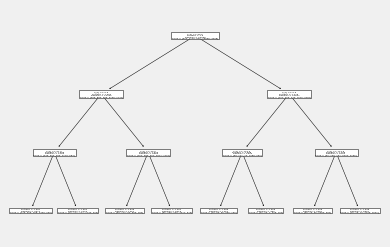

In [101]:
tree.plot_tree(dtree)

In [102]:
import graphviz

fn=['meaneduc', 'cielorazo']
cn=['class1', 'class2','class3','class4']

tree = tree.export_graphviz(dtree,
                     out_file= None,
                     feature_names = fn, 
                     class_names=cn,
                     filled = True )

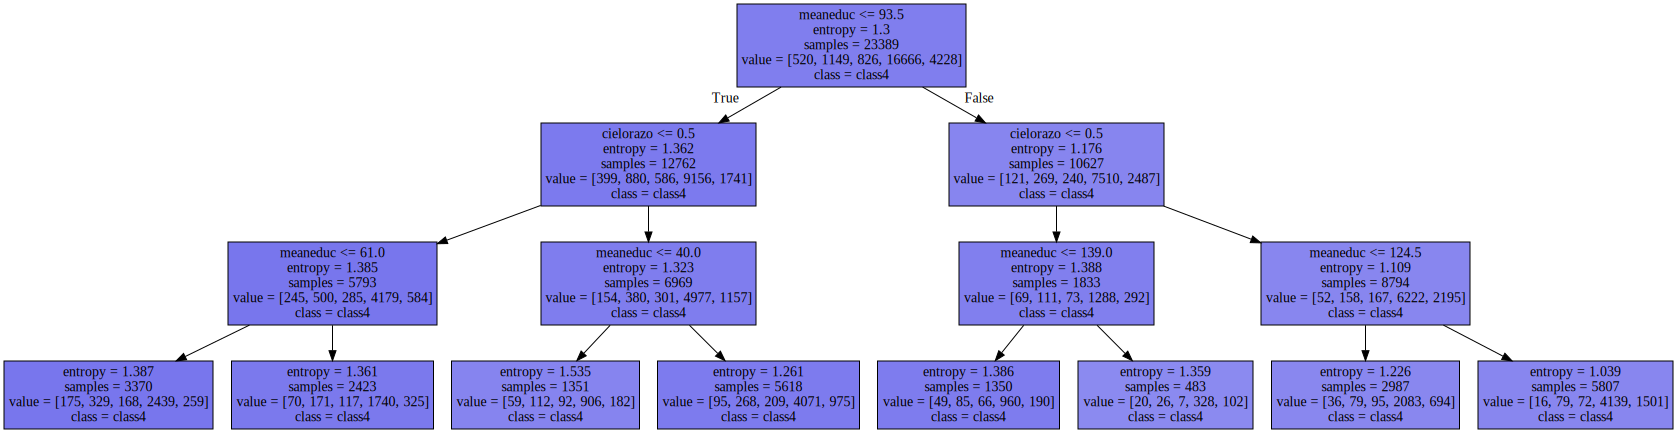

In [103]:
graph = graphviz.Source(tree, format="png") 
graph

In [104]:
cv_score = cross_val_score(dtree, train_set, train_labels, cv = kfold, scoring = scorer)

print(f'{kfold} Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

model_results = model_results.append(pd.DataFrame({'model': 'DecisionTree', 'cv_mean': cv_score.mean(), 'cv_std': cv_score.std()},index = [0]),ignore_index = True)

5 Fold Cross Validation F1 Score = 0.2511 with std = 0.0374


## Model - Naive Bayes

In [105]:
#import library
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()

In [106]:
cv_score = cross_val_score(GNB, train_set, train_labels, cv = kfold, scoring = scorer)
print(f'{kfold} Fold Cross Validation Macro F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')
model_results = model_results.append(pd.DataFrame({'model': 'GaussianNB', 'cv_mean': cv_score.mean(), 'cv_std': cv_score.std()},index = [1]),ignore_index = True)

5 Fold Cross Validation Macro F1 Score = 0.1835 with std = 0.0651


## Model - KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=12)

In [108]:
cv_score = cross_val_score(KNN, train_set, train_labels, cv = kfold, scoring = scorer)
print(f'{kfold} Fold Cross Validation Macro F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

model_results = model_results.append(pd.DataFrame({'model': 'KNN', 'cv_mean': cv_score.mean(), 'cv_std': cv_score.std()},index = [0]),ignore_index = True)

5 Fold Cross Validation Macro F1 Score = 0.3447 with std = 0.0286


In [109]:
KNN_predictions = pd.DataFrame()
for i, (train_index, test_index) in enumerate(kf.split(train_set, train_labels)):
    X_train, X_val = train_set.iloc[train_index], train_set.iloc[test_index]
    y_train, y_val = train_labels.iloc[train_index], train_labels.iloc[test_index]    
    KNN.fit(X_train, y_train)
    
    fold_prediction = pd.DataFrame()
    # Make predictions from the fold
    fold_prediction['Target'] = KNN.predict(test_set)
    fold_prediction['idhogar'] = test_ids
    fold_prediction['fold'] = (i+1)
    # Append fold prediction to predictions
    KNN_predictions = KNN_predictions.append(fold_prediction)

# Average the predictions over folds
KNN_predictions = KNN_predictions.groupby('idhogar', as_index = False).mean().round()
KNN_predictions = KNN_predictions.drop(columns = ['fold'])

## Model - Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)

In [111]:
cv_score = cross_val_score(RF, train_set, train_labels, cv = kfold, scoring = scorer)

print(f'{kfold} Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

model_results = model_results.append(pd.DataFrame({'model': 'RandomForest', 'cv_mean': cv_score.mean(), 'cv_std': cv_score.std()},index = [0]),ignore_index = True)

5 Fold Cross Validation F1 Score = 0.3264 with std = 0.0426


In [112]:
RF_predictions = pd.DataFrame()
for i, (train_index, test_index) in enumerate(kf.split(train_set, train_labels)):
    X_train, X_val = train_set.iloc[train_index], train_set.iloc[test_index]
    y_train, y_val = train_labels.iloc[train_index], train_labels.iloc[test_index]    
    RF.fit(X_train, y_train)
    
    fold_prediction = pd.DataFrame()
    # Make predictions from the fold
    fold_prediction['Target'] = RF.predict(test_set)
    fold_prediction['idhogar'] = test_ids
    fold_prediction['fold'] = (i+1)
    # Append fold prediction to predictions
    RF_predictions = RF_predictions.append(fold_prediction)
    
# Average the predictions over folds
RF_predictions = RF_predictions.groupby('idhogar', as_index = False).mean().round()
RF_predictions = RF_predictions.drop(columns = ['fold'])

## Model - Light Gradient Boosting Machine (LGBM)
Cross validation and early stopping to prevent overfitting

In [113]:
import lightgbm as lgbm
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

In [114]:
params = {
    #'boosting_type': 'dart', #Dropouts meet Multiple Additive Regression Trees
    'max_depth': -1, #max tree depth, <=0 means no limit
    'learning_rate': 0.03,
    'class_weight': 'balanced',
    'colsample_bytree': 0.93, #subsample ratio of columns when constructing each tree.
    'min_child_samples': 10, #Min number of data needed in a child (leaf)., default=20
    'num_leaves': 20, #Max tree leaves, default=31
    'subsample': 0.5, #Subsample ratio of the training instance.
    'num_class': 4,
}

LGBM = lgbm.LGBMClassifier(**params, objective='multiclass', metric='None', n_estimators= 10000)

In [115]:
LGBM_predictions = pd.DataFrame()
valid_scores = []

for i, (train_index, test_index) in enumerate(kf.split(train_set, train_labels)):
    print(f'##### Fold {i+1} #####')
    X_train, X_val = train_set.iloc[train_index], train_set.iloc[test_index]
    y_train, y_val = train_labels.iloc[train_index], train_labels.iloc[test_index]    
    LGBM.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], eval_names = ['train', 'valid'], early_stopping_rounds=400, verbose=100, eval_metric=macro_f1_score)
    valid_scores.append(LGBM.best_score_['valid']['macro_f1'])
    
    fold_prediction = pd.DataFrame()
    # Make predictions from the fold
    fold_prediction['Target'] = LGBM.predict(test_set)
    fold_prediction['idhogar'] = test_ids
    fold_prediction['fold'] = (i+1)
    # Append fold prediction to predictions
    LGBM_predictions = LGBM_predictions.append(fold_prediction)

# Average the predictions over folds
LGBM_predictions = LGBM_predictions.groupby('idhogar', as_index = False).mean().round()
LGBM_predictions = LGBM_predictions.drop(columns = ['fold'])
    
print('\n')
print(valid_scores)
print(f'{kfold} Fold Cross Validation Macro F1 Score = {round(np.mean(valid_scores), 4)} with std = {round(np.std(valid_scores), 4)}')
model_results = model_results.append(pd.DataFrame({'model': 'LightGBM', 'cv_mean': np.mean(valid_scores), 'cv_std': np.std(valid_scores)},index = [0]),ignore_index = True)

##### Fold 1 #####
Training until validation scores don't improve for 400 rounds
[100]	train's macro_f1: 0.833935	valid's macro_f1: 0.374364
[200]	train's macro_f1: 0.913073	valid's macro_f1: 0.353611
[300]	train's macro_f1: 0.959723	valid's macro_f1: 0.354546
[400]	train's macro_f1: 0.985403	valid's macro_f1: 0.35065
Early stopping, best iteration is:
[16]	train's macro_f1: 0.640759	valid's macro_f1: 0.39236
##### Fold 2 #####
Training until validation scores don't improve for 400 rounds
[100]	train's macro_f1: 0.825065	valid's macro_f1: 0.43158
[200]	train's macro_f1: 0.918339	valid's macro_f1: 0.429712
[300]	train's macro_f1: 0.962524	valid's macro_f1: 0.439478
[400]	train's macro_f1: 0.985581	valid's macro_f1: 0.429466
[500]	train's macro_f1: 0.997067	valid's macro_f1: 0.424738
[600]	train's macro_f1: 0.999481	valid's macro_f1: 0.425603
[700]	train's macro_f1: 1	valid's macro_f1: 0.416018
Early stopping, best iteration is:
[303]	train's macro_f1: 0.96294	valid's macro_f1: 0.446533


## Comparing Model

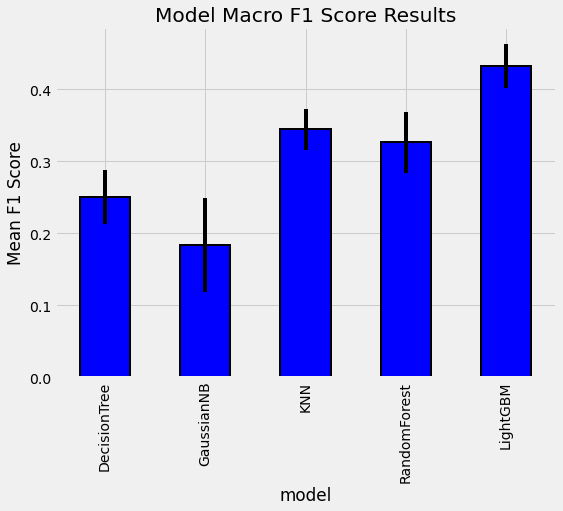

In [116]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'blue', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model Macro F1 Score Results');
plt.ylabel('Mean F1 Score');
model_results.reset_index(inplace = True)

In [117]:
result = pd.merge(LGBM_predictions, RF_predictions, on ="idhogar",suffixes=('_LGBM', '_RF'))
result = pd.merge(result, KNN_predictions, on='idhogar')
result.rename(columns = {'Target':'Target_KNN'}, inplace = True)
result.head()

,idhogar,Target_LGBM,Target_RF,Target_KNN
0,000a08204,4.0,4.0,4.0
1,000bce7c4,2.0,4.0,3.0
2,001845fb0,4.0,4.0,4.0
3,003514e22,4.0,4.0,4.0
4,003b51a87,2.0,2.0,1.0


 The matrix below shows the **correlation of predictions** between the top three model with highest mean F1 score (LGBM, RF and KNN). 

They are moderately positive correlated, thus it is reasonable to experiment combine them using voting classier.

In [118]:
result.corr()

,Target_LGBM,Target_RF,Target_KNN
Target_LGBM,1.000000,0.671520,0.565287
Target_RF,0.671520,1.000000,0.542704
Target_KNN,0.565287,0.542704,1.000000


# Ensemble of different algorithm

In [119]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('LGBM', LGBM), ('RF', RF), ('KNN', KNN)], voting='soft')
eclf = eclf.fit(train_set, train_labels)

In [120]:
eclf_predictions = pd.DataFrame()
eclf_predictions['idhogar'] = test_ids
eclf_predictions['Target'] = eclf.predict(test_set)
eclf_predictions.head()

,idhogar,Target
0,72958b30c,4
1,5b598fbc9,4
2,1e2fc704e,4
3,8ee7365a8,4
4,ff69a6fc8,4


In [121]:
print(model_results)


          model   cv_mean    cv_std
0  DecisionTree  0.251090  0.037367
1    GaussianNB  0.183490  0.065128
2           KNN  0.344741  0.028629
3  RandomForest  0.326392  0.042558
4      LightGBM  0.432320  0.030848


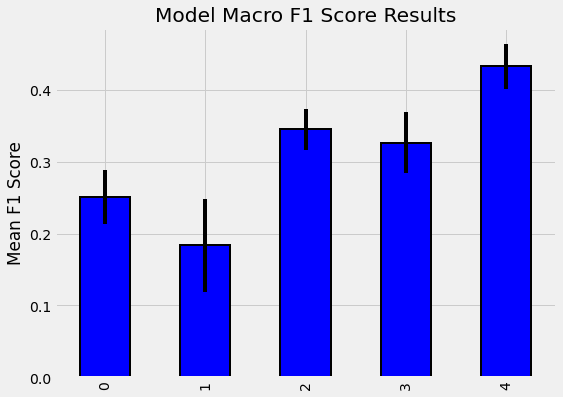

In [122]:

model_results['cv_mean'].plot.bar(color = 'blue', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model Macro F1 Score Results');
plt.ylabel('Mean F1 Score');
model_results.reset_index(inplace = True)

## Feature Importance

### Feature Importance of LightGradient Boost

In [123]:
feature_importances = pd.DataFrame(LGBM.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', 
                                   ascending=False)
feature_importances.head(10)

,importance
age_std,1122
age_sum,927
age_min,759
age_max,751
meaneduc,744
escolari/age_std,739
escolari_std,693
escolari/age_sum,615
inst/age_max,603
inst/age_std,596


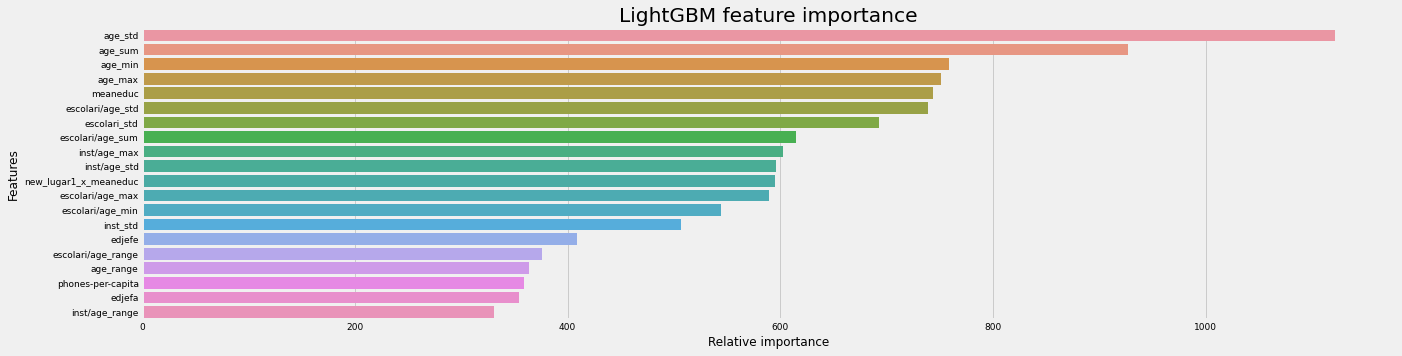

In [124]:
indices = np.argsort(LGBM.feature_importances_)[::-1]
indices = indices[:20]

# Visualise these with a barplot
plt.subplots(figsize=(20, 5))
g = sns.barplot(y=train_set.columns[indices], x = LGBM.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance");

### Feature Importance of Random Forest

In [125]:
feature_importances = pd.DataFrame(RF.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', 
                                   ascending=False)
feature_importances.head(10)

,importance
meaneduc,0.019493
escolari_max,0.016682
escolari/age_max,0.014953
escolari_min,0.014420
age_min,0.013944
escolari/age_min,0.013848
inst_max,0.013815
escolari_sum,0.013154
phones-per-capita,0.013086
escolari/age_sum,0.012850


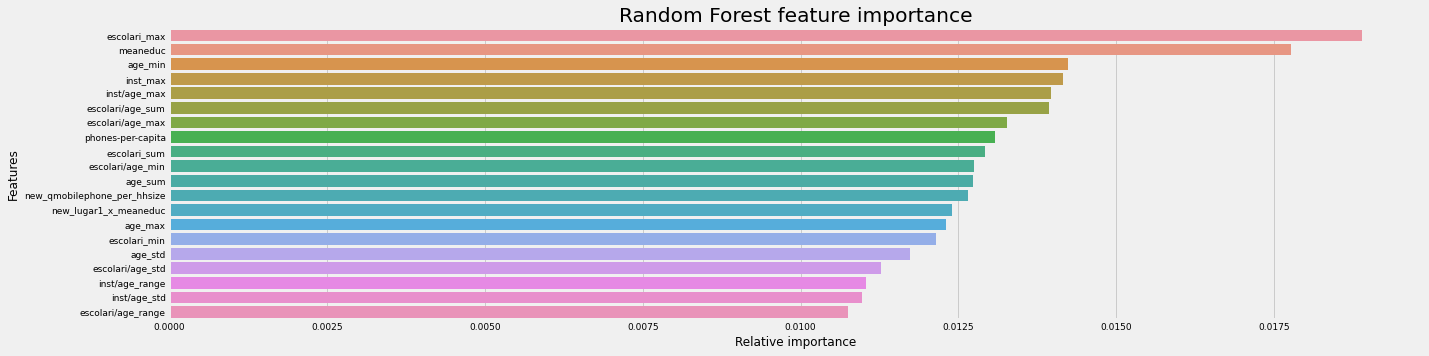

In [126]:
RF.fit(train_set, train_labels)

indices = np.argsort(RF.feature_importances_)[::-1]
indices = indices[:20]

# Visualise these with a barplot
plt.subplots(figsize=(20, 5))
g = sns.barplot(y=train_set.columns[indices], x = RF.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random Forest feature importance");

# Feature Selection

For this part, we will perform feature selection to improve the model performance by keeping the most useful features for the models. Previously, we have removed column with correlation with greater than 0.95 in the Feature Engineering. To move on, we wil use Recursive Feature Elimination(RFE) with cross validation from the sklearn library. The selector will remove features in each iteraction until the cv scores is not improving anymore. We will apply RFECV to the best 3 performance models which are **Random Forest and Light Gradient Boosting** but not kNeighbours as it does not expose "coef_" or "feature_importances_" attributes

## RFECV with Random Forest

After running RFECV on RF, we discovered that the macro score peaked at 59 features, and decrease as more features used. (refer to the graph in previous version).

In [127]:
# from sklearn.feature_selection import RFECV

# # Create a model for feature selection
# estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)
# # Create the object
# selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

# #fit the selector on training data until it reached the optimal cv score
# selector.fit(train_set, train_labels)

In [128]:
#then we plot the number of features versus the F1 score
#plt.plot(selector.grid_scores_);
#plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
#selector.n_features_

In [129]:
#feature ranking
# rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
# rankings.head(10)

In [130]:
#select the features and use them to evaluate the model again in cross validation
#train_selected = selector.transform(train_set)
#test_selected = selector.transform(test_set)

In [131]:
# construct dataframe with selected feature for training
#selected_features = train_set.columns[np.where(selector.ranking_==1)]

From the output of the codes above, here are the 59 features that ranked 1.

In [132]:
selected_features = ['new_qmobilephone_per_hhsize',
'new_rooms_per_hhsize',
'new_rooms_per_r4t2',
'new_rooms_per_r4m3',
'new_rooms_per_r4m2',
'new_rooms_per_r4h3',
'new_rooms_per_r4h2',
'new_rooms_per_hogar_nin',
'new_rooms_per_hogar_adul',
'new_rooms_per_adult',
'age_std',
'rent-per-capita',
'rooms-per-capita',
'phones-per-capita',
'males_in_household_size',
'males_older_12_years_in_household_size',
'adult_percent',
'child_percent',
'dependency_count',
'rooms',
'overcrowding',
'meaneduc',
'new_bedrooms_per_adult',
'edjefe',
'new_bedrooms_per_hogar_adul',
'new_bedrooms_per_r4m3',
'age_max',
'age_min',
'escolari_range',
'age_range',
'escolari_std',
'escolari_sum',
'escolari_max',
'escolari_min',
'inst_max',
'inst_std',
'new_etecho3_x_eviv3',
'new_epared3_x_eviv3',
'no_appliances',
'new_lugar1_x_meaneduc',
'new_qmobilephone_per_r4t2',
'new_qmobilephone_per_r4m3',
'new_qmobilephone_per_r4h3',
'new_qmobilephone_per_r4h2',
'new_qmobilephone_per_adult',
'new_bedrooms_per_hhsize',
'new_bedrooms_per_r4t2',
'new_bedrooms_per_r4h3',
'dependency',
'age_sum',
'escolari/age_max',
'escolari/age_sum',
'escolari/age_std',
'cielorazo',
'escolari/age_range',
'inst/age_max',
'escolari/age_min',
'inst/age_std',
'inst/age_range',
'new_bedrooms_per_r4h2']


train_selected = train_set[selected_features]
test_selected = test_set[selected_features]

In [133]:
cv_score = cross_val_score(RF, train_selected, train_labels, cv = kfold, scoring = scorer)
print(f'{kfold} Fold Cross Validation Macro F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')
model_results = model_results.append(pd.DataFrame({'model': 'RF_SEL', 'cv_mean': cv_score.mean(), 'cv_std': cv_score.std()},index = [0]),ignore_index = True)

5 Fold Cross Validation Macro F1 Score = 0.3643 with std = 0.0216


The original F1-score for random forest model **without selected feature** is **0.3264**.
The F1-score for random forest model **with selected feature** is **0.3643**. It has improved!!

## RFECV with Light Gradient Boost Machine¶
After running RFECV on LGBM, we discovered that the macro score peaked at 13 features, and deteriorate as more features used. (refer to the graph in previous version).

In [134]:
# LGBM2 = lgbm.LGBMClassifier(**params, objective='multiclass', metric='None', n_estimators=400)

# selector_lgbm = RFECV(LGBM2, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

# selector_lgbm.fit(train_set, train_labels)

In [135]:
# #then we plot the number of features versus the F1 score
#plt.plot(selector_lgbm.grid_scores_);
#plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
#selector_lgbm.n_features_

In [136]:
# #feature ranking
# #selected_features = train_set.columns[np.where(selector.ranking_==1)]
# ranking_lgbm = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector_lgbm.ranking_)}).sort_values('rank')
# ranking_lgbm.head(10)

In [137]:
#select the features and use them to evaluate the model again in cross validation
#train_selected_lgbm = selector_lgbm.transform(train_set)
#test_selected_lgbm = selector_lgbm.transform(test_set)

From the output of the codes above, here are the selected features that ranked 1.

In [138]:
selected_features_lgbm = ['escolari/age_std','escolari/age_sum','new_rooms_per_hogar_adul','escolari_std','inst/age_std','age_min','age_max','age_std','age_sum','meaneduc']

train_selected_lgbm = train_set[selected_features_lgbm]
test_selected_lgbm = test_set[selected_features_lgbm]

Here we also experiment with the 59 selected features from RV

In [139]:
LGBM_RF_SEL_predictions = pd.DataFrame()
valid_scores = []

for i, (train_index, test_index) in enumerate(kf.split(train_selected, train_labels)):
    print(f'##### Fold {i+1} #####')
    X_train, X_val = train_selected.iloc[train_index], train_selected.iloc[test_index]
    y_train, y_val = train_labels.iloc[train_index], train_labels.iloc[test_index]    
    LGBM.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], eval_names = ['train', 'valid'], early_stopping_rounds=400, verbose=100, eval_metric=macro_f1_score)
    valid_scores.append(LGBM.best_score_['valid']['macro_f1'])
    
    fold_prediction = pd.DataFrame()
    # Make predictions from the fold
    #fold_prediction['Target'] = LGBM.predict(test_set)
    fold_prediction['Target'] = LGBM.predict(test_selected)
    
    fold_prediction['idhogar'] = test_ids
    fold_prediction['fold'] = (i+1)
    # Append fold prediction to predictions
    LGBM_RF_SEL_predictions = LGBM_RF_SEL_predictions.append(fold_prediction)
    
# Average the predictions over folds
LGBM_RF_SEL_predictions = LGBM_RF_SEL_predictions.groupby('idhogar', as_index = False).mean().round()
LGBM_RF_SEL_predictions = LGBM_RF_SEL_predictions.drop(columns = ['fold'])

print('\n')
print(valid_scores)
print(f'{kfold} Fold Cross Validation Macro F1 Score = {round(np.mean(valid_scores), 4)} with std = {round(np.std(valid_scores), 4)}')
model_results = model_results.append(pd.DataFrame({'model': 'LGBM_RF_SEL', 'cv_mean': np.mean(valid_scores), 'cv_std': np.std(valid_scores)},index = [0]),ignore_index = True)

##### Fold 1 #####
Training until validation scores don't improve for 400 rounds
[100]	train's macro_f1: 0.828948	valid's macro_f1: 0.42475
[200]	train's macro_f1: 0.901311	valid's macro_f1: 0.424286
[300]	train's macro_f1: 0.943751	valid's macro_f1: 0.409723
[400]	train's macro_f1: 0.972172	valid's macro_f1: 0.403133
[500]	train's macro_f1: 0.989272	valid's macro_f1: 0.400391
Early stopping, best iteration is:
[143]	train's macro_f1: 0.870864	valid's macro_f1: 0.440992
##### Fold 2 #####
Training until validation scores don't improve for 400 rounds
[100]	train's macro_f1: 0.800221	valid's macro_f1: 0.386644
[200]	train's macro_f1: 0.893826	valid's macro_f1: 0.414869
[300]	train's macro_f1: 0.941044	valid's macro_f1: 0.408272
[400]	train's macro_f1: 0.966058	valid's macro_f1: 0.430835
[500]	train's macro_f1: 0.987084	valid's macro_f1: 0.418695
[600]	train's macro_f1: 0.996473	valid's macro_f1: 0.41383
[700]	train's macro_f1: 0.999481	valid's macro_f1: 0.404757
Early stopping, best iter

The original F1-score for LGBM model **without selected feature** is **0.4313**.
The F1-score for LGBM model **with selected feature** is **0.4477**.

### Comparing models with feature selected

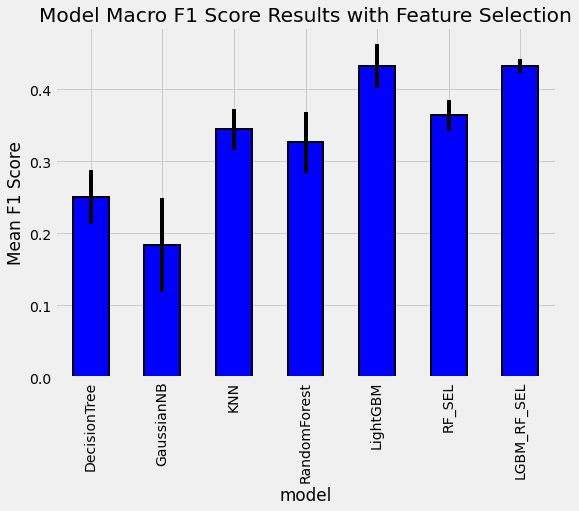

In [140]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'blue', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model Macro F1 Score Results with Feature Selection');
plt.ylabel('Mean F1 Score');
model_results.reset_index(inplace = True)

For the KNeighborsClassifier, it's object has no attribute 'feature_importances_'.

# Submission

In [141]:
submission = submission_base.merge(LGBM_predictions, on = 'idhogar',how = 'left').drop(columns = ['idhogar'])
#submission = submission_base.merge(LGBM_RF_SEL_predictions, on = 'idhogar',how = 'left').drop(columns = ['idhogar'])
#submission = submission_base.merge(LGBM_SEL_predictions, on = 'idhogar',how = 'left').drop(columns = ['idhogar'])
submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
submission.to_csv('submission.csv', index = False)

In [142]:
submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4
